In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
# read in dataframe
df = pd.read_csv('final_data_files/uncrowded_everything_all_clipped.csv')#_clipped.csv')

# show column names for reference
print df.columns.values

['id' 'type' 'per' 'mag_j' 'merr_j' 'mag_h' 'merr_h' 'mag_k' 'merr_k'
 'mag_3' 'merr_3' 'mag_4' 'merr_4' 'resid_m4_j' 'resid_m4_h' 'resid_m4_k'
 'resid_m4_3' 'resid_m4_4' 'resid_all_j' 'resid_all_h' 'resid_all_k'
 'resid_all_3' 'resid_all_4' 'photfeh' 'photfeh_err' 'spectfeh'
 'spectfeh_err']


In [3]:
df_s = pd.read_csv('final_data_files/sollima_2006.cat', delim_whitespace=True, index_col=False)
df_p = pd.read_csv('final_data_files/rey_2000.cat', delim_whitespace=True, index_col=False)

In [4]:
dfab = df[df.type == 0]
dfc = df[df.type == 1]

print df.shape
print dfab.shape
print dfc.shape

(163, 27)
(48, 27)
(51, 27)


In [5]:
# get color and color error values
df['color'] = df.mag_3 - df.mag_4
df['color_err'] = np.sqrt(df.merr_3**2 + df.merr_4**2)

In [6]:
# select only rows with non-nan residuals; this is equivalent
# to selecting rows with data in all wavelengths
condition_1 = (np.isfinite(df.resid_all_3))
# select only rows with non-nan spectroscopic metallicities
condition_2 = (np.isfinite(df.spectfeh))
# select only rows with non-nan photometric metallicities
condition_3 = (np.isfinite(df.photfeh))

condition_4 = (np.isfinite(df.resid_all_4))

# create new dataframes based on conditions
# star with id=103 is an outlier so we take it out
# and make a new dataframe with it so it's
# excluded from the linear fit but still plottable
df1 = df[condition_1 & condition_2]
df2 = df[condition_1 & condition_3]
df3 = df[condition_4 & condition_2]
df4 = df[condition_4 & condition_3]

# create lists of values for use in the plotting loop
# order is important here
resids = [df1.resid_all_3, df2.resid_all_3, df3.resid_all_4, df4.resid_all_4]
fehs = [df1.spectfeh, df2.photfeh, df3.spectfeh, df4.photfeh]
resid_errs = [df1.merr_3, df2.merr_3, df3.merr_4, df4.merr_4]
feh_errs = [df1.spectfeh_err, df2.photfeh_err, df3.spectfeh_err, df4.photfeh_err]

dfs = [df1, df2, df3, df4]

def get_type_list(inlist):
    outlist = []
    for i,obj in enumerate(inlist):
        outlist.append(obj[dfs[i].type==0])
    for i,obj in enumerate(inlist):
        outlist.append(obj[dfs[i].type==1])
    outlist = outlist[:2] + outlist[4:6] + outlist[2:4] + outlist[6:]
    return outlist

labels=['RRab, spectroscopic, [3.6]',
        'RRab, photometric, [3.6]',
        'RRab, spectroscopic, [4.5]',
        'RRab, photometric, [4.5]',
        'RRc, spectroscopic, [3.6]',
        'RRc, photometric, [3.6]',
        'RRc, spectroscopic, [4.5]',
        'RRc, photometric, [4.5]']

labels = labels[:2] + labels[4:6] + labels[2:4] + labels[6:]

resids2 = get_type_list(resids)
fehs2 = get_type_list(fehs)
resid_errs2 = get_type_list(resid_errs)
feh_errs2 = get_type_list(feh_errs)

74 57 38 36
RRab, spectroscopic, [3.6] 0.232417192736 0.612714409917
RRab, photometric, [3.6] 0.275219889642 0.4626692081
RRc, spectroscopic, [3.6] 0.144529889258 0.847845979969
RRc, photometric, [3.6] 0.265626879078 0.275531857249
RRab, spectroscopic, [4.5] 0.215148785727 0.83902326501
RRab, photometric, [4.5] 0.285402033959 0.55474524831
RRc, spectroscopic, [4.5] 0.107496769977 2.73811641951
RRc, photometric, [4.5] 0.244409364591 0.815242074018


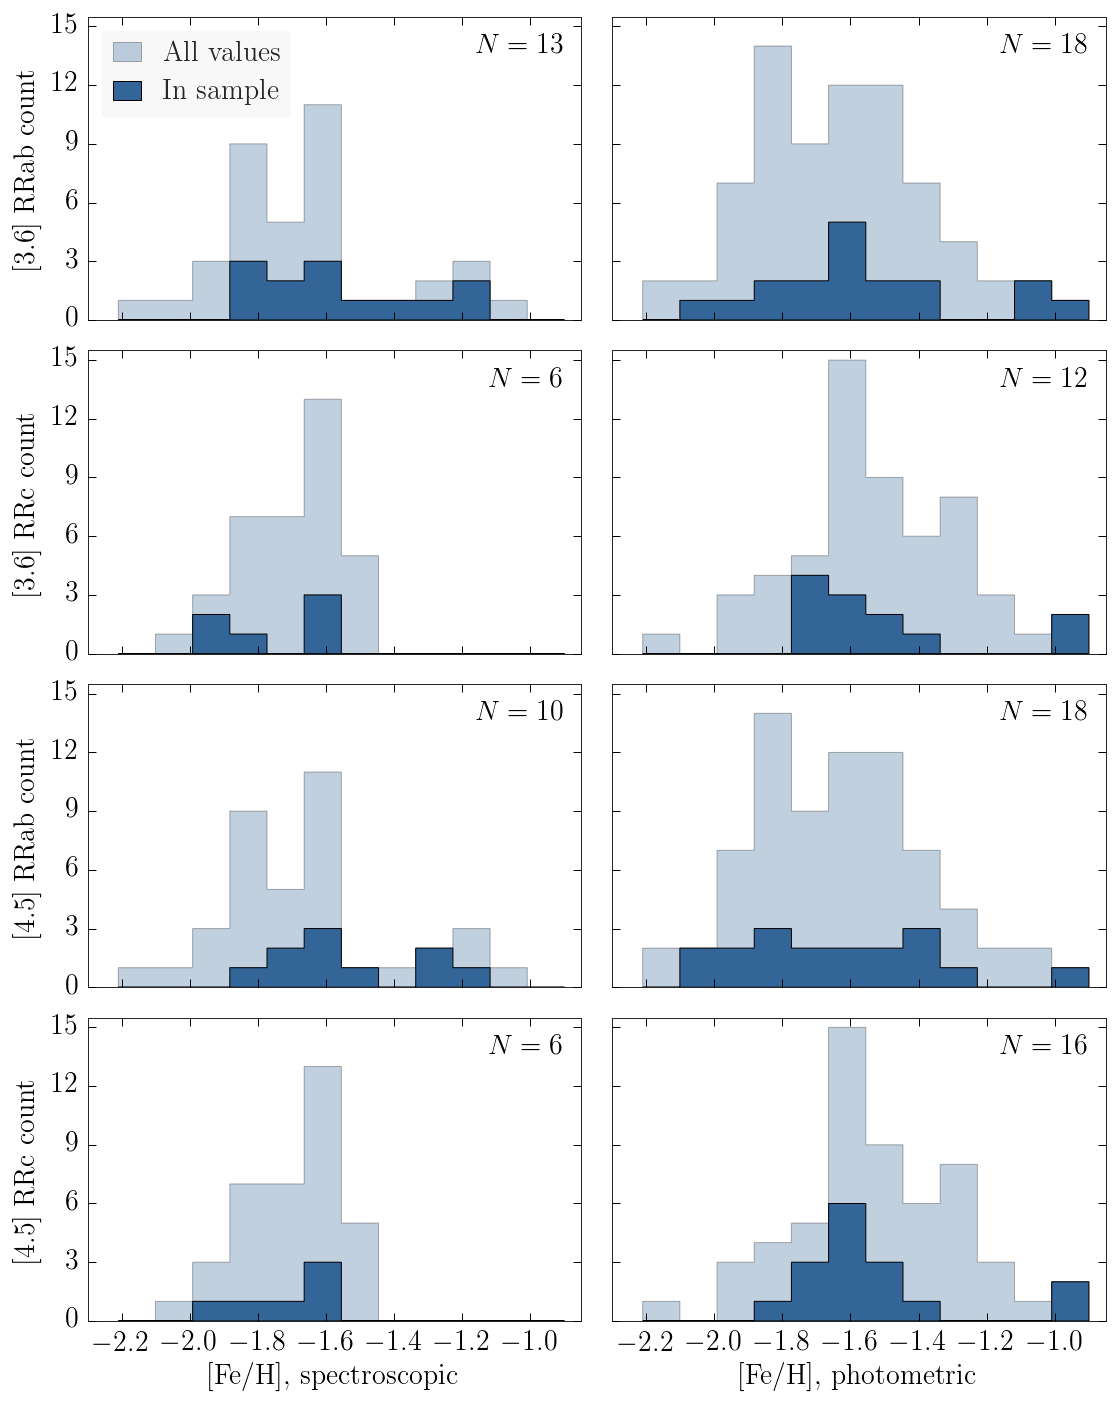

In [7]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharey=True, sharex=True, figsize=(8,10))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

phot = df_p.photfeh[np.isfinite(df_p.photfeh)].values
spect = df_s.spectfeh[np.isfinite(df_s.spectfeh)].values

photab = df_p.photfeh[(df_p.type == 0)].values
photc = df_p.photfeh[(df_p.type == 1)].values
spectab = df_s.spectfeh[(df_s.type == 0)].values
spectc = df_s.spectfeh[(df_s.type == 1)].values

print len(photab), len(photc), len(spectab), len(spectc)

from astroML.plotting import hist

n, b, patches = hist(phot, bins='knuth', alpha=0)
bins = np.linspace(b.min(), b.max(), len(b)*1.2)
# bins = np.linspace(phot.min() + 0.5*phot.min(),phot.max()-0.5*phot.max(),84)

ax1.hist(spectab, bins=bins, histtype='stepfilled', color='#346598', linewidth=0.5, alpha=0.3, label='All values')
ax2.hist(photab, bins=bins, histtype='stepfilled', color='#346598', linewidth=0.5, alpha=0.3)
ax3.hist(spectc, bins=bins, histtype='stepfilled', color='#346598', linewidth=0.5, alpha=0.3)
ax4.hist(photc, bins=bins, histtype='stepfilled', color='#346598', linewidth=0.5, alpha=0.3)

ax5.hist(spectab, bins=bins, histtype='stepfilled', color='#346598', linewidth=0.5, alpha=0.3, label='All values')
ax6.hist(photab, bins=bins, histtype='stepfilled', color='#346598', linewidth=0.5, alpha=0.3)
ax7.hist(spectc, bins=bins, histtype='stepfilled', color='#346598', linewidth=0.5, alpha=0.3)
ax8.hist(photc, bins=bins, histtype='stepfilled', color='#346598', linewidth=0.5, alpha=0.3)

# fix this shit wtf
# plot the things
for i in range(8):
    print labels[i], np.std(fehs2[i].values), np.std(resids2[i].values) / np.std(fehs2[i].values)
    ax[i].hist(fehs2[i].values, bins=bins, color='#346598', histtype='stepfilled', label='In sample', linewidth=0.5)
    ax[i].text(-0.9,13.6,'$N={}$'.format(len(fehs2[i].values)), ha='right')
    #ax[i].set_xlabel(labels[i])
    ppl.plot(ax[i], [],[])
ax7.set_xlabel('[Fe/H], spectroscopic')
ax8.set_xlabel('[Fe/H], photometric')
ax1.set_ylabel('[3.6] RRab count')
ax3.set_ylabel('[3.6] RRc count')
ax5.set_ylabel('[4.5] RRab count')
ax7.set_ylabel('[4.5] RRc count')
ax1.set_ylim(0.,15.5)
ax1.set_yticks(np.linspace(0,15,6))
ax1.set_xlim(-2.3,-0.85)
ppl.legend(ax1, loc='upper left', prop={'size':14}, handlelength = 1)

fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
fig.savefig('final_plots/metallicity_hists.pdf')

In [9]:
#3.6 ab 0.0609201346162 / 0.249645871069  / 0.253562815756
#3.6 c 0.0460132246303 / 0.132020153718  / 0.242967698583
#4.5 ab 0.160184654133 / 0.249645871069  / 0.253562815756
#4.5 c 0.187422270401 / 0.132020153718  / 0.242967698583

# 3 ab 0.0877299290377 0.04 0.047870371665 0.0616844223902
# 3 c 0.102368199291 0.079 0.0409453923154 0.0506134673199
# 4 ab 0.172970474517 0.045 0.0468873844024 0.160297717509
# 4 c 0.20180292728 0.057 0.0477328639205 0.187608622298
import numpy as np

sig = [0.106, 0.034, 0.140, 0.205]
spect = [0.249645871069, 0.132020153718, 0.249645871069, 0.132020153718]
phot = [0.253562815756, 0.242967698583, 0.253562815756, 0.242967698583]

for i in range(4):
    print (sig[i]/spect[i], sig[i]/phot[i], np.round(sig[i]/spect[i], decimals=3),
           np.round(sig[i]/phot[i], decimals=3))

(0.4246014546369265, 0.41804236825482466, 0.42499999999999999, 0.41799999999999998)
(0.2575364369945007, 0.1399362968752214, 0.25800000000000001, 0.14000000000000001)
(0.5607943740487709, 0.5521314297705232, 0.56100000000000005, 0.55200000000000005)
(1.5527932230550776, 0.8437335546888349, 1.5529999999999999, 0.84399999999999997)
